In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hierarchical Bayesian Models

A few really simple HBM models

## Model 1

Let's start with a really simple model.  We have $x$ and $y$ and nature knows that $y = 2 x + 2$.

### Simulating Data

If we are to simulate some data we will say that we have observed some $x_{\rm obs}$ and some $y_{\rm obs}$.  Our observed data has noise on it (additive Gaussian noise) so that,

$x_{i, \rm obs} = x_i + \mathcal{N}(0, 1)$,

$y_{i, \rm obs} = y_i + \mathcal{N}(0, 1)$.

Let's just start by simulating that data:

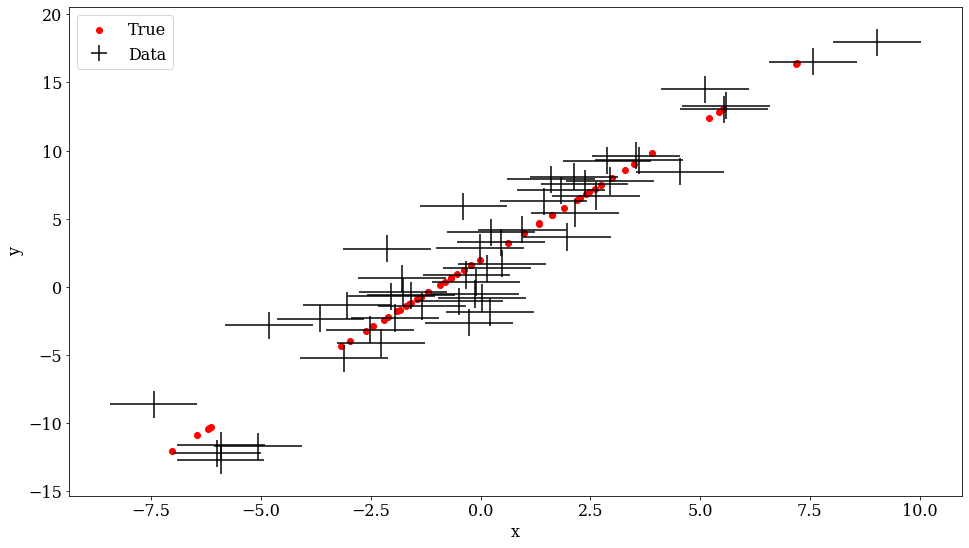

In [53]:
np.random.seed(53) # What is 53 in hexidecimal?
npts = 50
m = 2
c = 2
x_err = np.ones(npts)
y_err = np.ones(npts)

x = np.random.randn(npts) * 3
y = m*x + c

x_obs = x + np.random.randn(npts) * x_err
y_obs = y + np.random.randn(npts) * y_err

fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(x, y, c='r', label='True')
ax.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err, linestyle='none', c='k', label='Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc=2)

### Simple model 1

We will use pymc3 to model this data.  Pymc3 has a very easy to use HMC (NUTS) sampler.  First we build the model we want to fit.  We need parameters $m$ and $c$ and priors :

$m \sim \mathcal{N}(0, 10)$,

$c \sim \mathcal{N}(0, 10)$.

We are also going to setup latent variables in $x$.  We will have a parameter $x_{i, l}$ for every $x_{i, obs}$ data point.  We need to set these up with a weak prior:

${\mathbf x_l} \sim \mathcal{N}(0, 1000)$.

And we need the deterministic part of our model:

${\mathbf y_l} = m {\mathbf x_l} + c $.

Finally, we can compare out latent $x_{i, l}$ and $y_{i, l}$ with our observed $x_{i, obs}$ and $y_{i, obs}$:

${\mathbf x_{obs}} \sim \mathcal{N}({\mathbf x_l}, x_{err})$

${\mathbf y_{obs}} \sim \mathcal{N}({\mathbf y_l}, y_{err})$

Let's put this into a probabilistic graphical model (PGM) ...

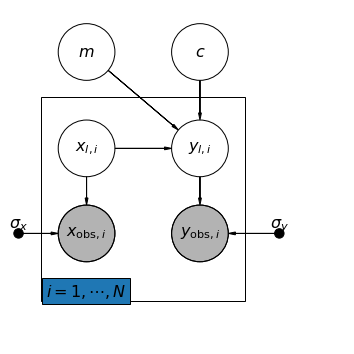

In [54]:
''' You might need to pip install daft and update matplotlib to get this to work '''

from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical prior parameters.
pgm.add_node(daft.Node("m", r"$m$", 0.7, 2.6))
pgm.add_node(daft.Node("c", r"$c$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("x_l", r"$x_{l,i}$", 0.7, 1.75))
pgm.add_node(daft.Node("y_l", r"$y_{l,i}$", 1.7, 1.75))
# Data.
pgm.add_node(daft.Node("x_obs", r"$x_{{\rm obs},i}$", 0.7, 1, observed=True))
pgm.add_node(daft.Node("y_obs", r"$y_{{\rm obs},i}$", 1.7, 1, observed=True))
# Unc
pgm.add_node(daft.Node("yerr", r"$\sigma_{y}$", 2.4, 1.0, fixed=True))
pgm.add_node(daft.Node("xerr", r"$\sigma_{x}$", 0.1, 1.0, fixed=True))
# Add in the edges.
pgm.add_edge("m", "y_l")
pgm.add_edge("c", "y_l")
pgm.add_edge("x_l", "y_l")

pgm.add_edge("x_l", "x_obs")
pgm.add_edge("y_l", "y_obs")

pgm.add_edge("yerr", "y_obs")
pgm.add_edge("xerr", "x_obs")

# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

And now let's code this up in pymc3!

In [55]:
import pymc3 as pm

with pm.Model() as model:
    m = pm.Normal('m', 0.0, 10.0, testval=1)
    c = pm.Normal('c', 0.0, 10.0, testval=-1)
    
    x_l = pm.Normal('x_latent', 0.0, 1000.0, shape=len(x_obs), testval=x_obs)
    
    y_l = m * x_l + c
    
    y_observed = pm.Normal('y_obs', y_l, y_err, observed=y_obs)
    x_observed = pm.Normal('x_obs', x_l, x_err, observed=x_obs)

Pymc3 is super easy to use so we can run the sampler: 

In [56]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_latent, c, m]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2799.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


And then look at the results:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6044b56d68>,
      dtype=object)

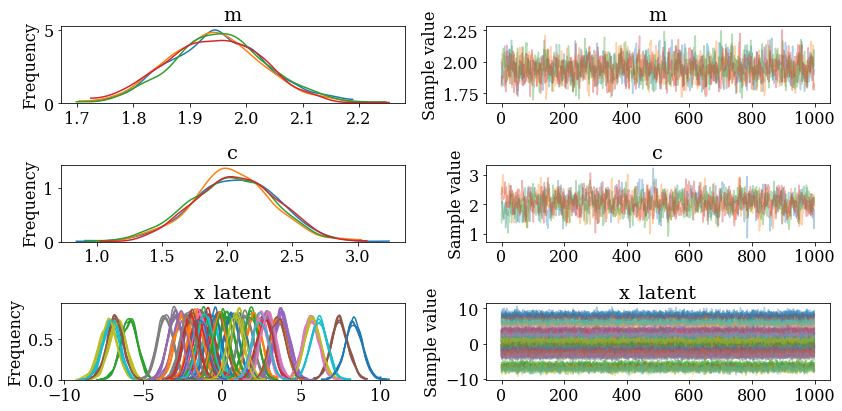

In [57]:
pm.traceplot(trace)

In [58]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,1.95,0.08,0.00,1.78,2.11,1198.04,1.0
c,2.04,0.31,0.01,1.44,2.66,752.38,1.0
x_latent__0,0.60,0.48,0.01,-0.32,1.53,3786.91,1.0
x_latent__1,3.54,0.50,0.01,2.57,4.51,3133.97,1.0
x_latent__2,-5.89,0.52,0.01,-6.91,-4.88,2330.36,1.0
x_latent__3,-1.36,0.49,0.01,-2.31,-0.40,3313.27,1.0
x_latent__4,2.75,0.48,0.01,1.76,3.67,3174.55,1.0
x_latent__5,7.46,0.54,0.01,6.47,8.56,2382.73,1.0
x_latent__6,-1.53,0.49,0.01,-2.50,-0.56,3424.74,1.0
x_latent__7,2.89,0.48,0.01,1.99,3.85,4128.60,1.0


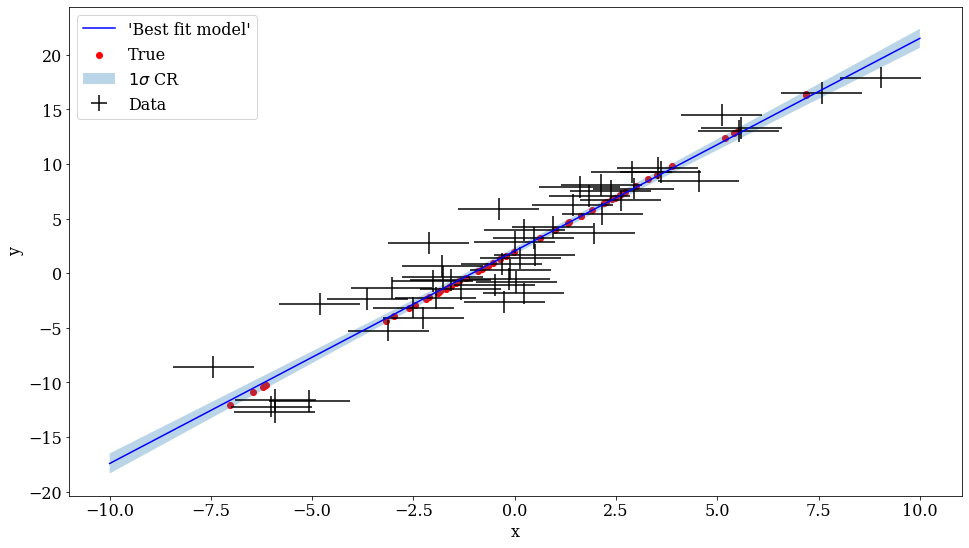

In [59]:
fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(x, y, c='r', label='True')
ax.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err, linestyle='none', c='k', label='Data')

xx = np.linspace(-10, 10, 100)
est = [mm*xx+cc for mm, cc in zip(trace['m'], trace['c'])]
std = np.std(est, axis=0)
mean = np.mean(est, axis=0)

ax.plot(xx, mean, c='b', label="'Best fit model'")
ax.fill_between(xx, mean+std, mean-std, alpha=0.3, label=r'$1 \sigma$ CR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc=2)

## Model 2

Another really simple model but mother nature is a distribution.  We have $x$ and $y$ and nature knows that $y = 2 x + 2 + \mathcal{N}(0,2)$.

If we are to simulate some data we will say that we have observed some $x_{\rm obs}$ and some $y_{\rm obs}$.  Our observed data has observational noise on it (additive Gaussian noise) so that,

$x_{\rm obs} = x + \mathcal{N}(0, 1)$,

$y_{\rm obs} = y + \mathcal{N}(0, 1)$.

Let's just start by simulating that data:

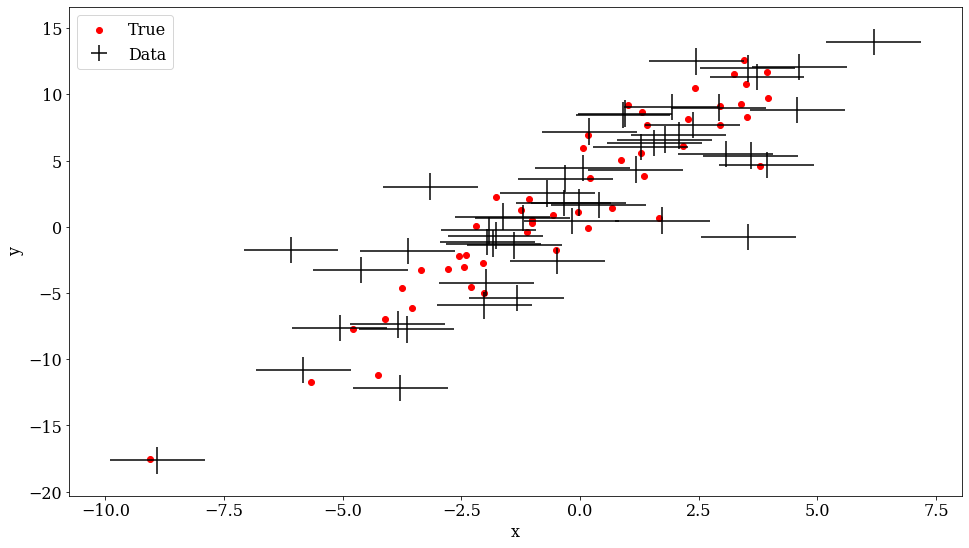

In [99]:
np.random.seed(35) # What is 0x35 in decimal?
npts = 50
m = 2
c = 2
sigma = 2
x_err = np.ones(npts)
y_err = np.ones(npts)

x = np.random.randn(npts) * 3
y = m*x + c + np.random.randn(npts) * sigma

x_obs = x + np.random.randn(npts) * x_err
y_obs = y + np.random.randn(npts) * y_err

fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(x, y, c='r', label='True')
ax.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err, linestyle='none', c='k', label='Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc=2)

### Simple model 2

We will use pymc3 to model this data.  Pymc3 has a very easy to use HMC (NUTS) sampler.  First we build the model we want to fit.  We need parameters $m$, $c$, and $\sigma$ with priors (see later for what $\sigma$ does):

$m \sim \mathcal{N}(0, 10)$,

$c \sim \mathcal{N}(0, 10)$,

$\sigma \sim \mathcal{N}(0, 1)$.

We are also going to setup latent variables in $x$.  We will have a parameter $x_{i, l}$ for every $x_{i, obs}$ data point.  We need to set these up with a weak prior:

${\mathbf x_l} \sim \mathcal{N}(0, 1000)$.

We will also have a parameter $y_{i, std}$ for every value of $x_{i, l}$.  These $y_{i, std}$ values will always be distirbuted as $\mathcal{N}(0, 1)$ - always.  These parameters will 'order' the spread in our relation.  We will then scale the spread by $\sigma$.  The spread is then added on to our deterministic model so:

${\mathbf y_{std}} \sim \mathcal{N}(0, 1)$,

${\mathbf y_{pred}} = m {\mathbf x_l} + c + \sigma {\mathbf y_{std}}$.

Finally, we can compare out latent $x_{i, l}$ and $y_{i, pred}$ with our observed $x_{i, obs}$ and $y_{i, obs}$:

${\mathbf x_{obs}} \sim \mathcal{N}({\mathbf x_l}, x_{err})$,

${\mathbf y_{obs}} \sim \mathcal{N}({\mathbf y_{pred}}, y_{err})$.

Let's put this into a probabilistic graphical model (PGM) ...

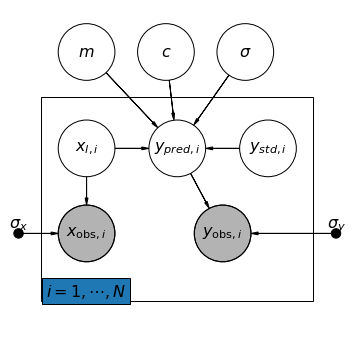

In [108]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical prior parameters.
pgm.add_node(daft.Node("m", r"$m$", 0.7, 2.6))
pgm.add_node(daft.Node("c", r"$c$", 1.4, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 2.1, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("x_l", r"$x_{l,i}$", 0.7, 1.75))
pgm.add_node(daft.Node("y_l", r"$y_{pred,i}$", 1.5, 1.75))
pgm.add_node(daft.Node("y_std", r"$y_{std,i}$", 2.3, 1.75))
# Data.
pgm.add_node(daft.Node("x_obs", r"$x_{{\rm obs},i}$", 0.7, 1, observed=True))
pgm.add_node(daft.Node("y_obs", r"$y_{{\rm obs},i}$", 1.9, 1, observed=True))
# Unc
pgm.add_node(daft.Node("yerr", r"$\sigma_{y}$", 2.9, 1.0, fixed=True))
pgm.add_node(daft.Node("xerr", r"$\sigma_{x}$", 0.1, 1.0, fixed=True))
# Add in the edges.
pgm.add_edge("m", "y_l")
pgm.add_edge("c", "y_l")
pgm.add_edge("sigma", "y_l")

pgm.add_edge("x_l", "y_l")
pgm.add_edge("y_std", "y_l")

pgm.add_edge("x_l", "x_obs")
pgm.add_edge("y_l", "y_obs")

pgm.add_edge("yerr", "y_obs")
pgm.add_edge("xerr", "x_obs")

# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 2.4, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

And now let's code this up in pymc3!

In [101]:
with pm.Model() as model:
    m = pm.Normal('m', 0.0, 10.0, testval=2)
    c = pm.Normal('c', 0.0, 10.0, testval=2)
    sigma = pm.HalfNormal('sigma', 1.0, testval=2)
    
    x_l = pm.Normal('x_latent', 0.0, 1000.0, shape=len(x_obs), testval=x_obs)
    
    y_std = pm.Normal('y_std', 0.0, 1.0, shape=len(x_obs))
    y_pred = m * x_l + c + (y_std * sigma)
    
    y_observed = pm.Normal('y_obs', y_pred, y_err, observed=y_obs)
    x_observed = pm.Normal('x_obs', x_l, x_err, observed=x_obs)

And then look at the results again.

In [102]:
with model:
    trace = pm.sample(1000, tune=2000, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_std, x_latent, sigma, c, m]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 985.12draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60385dd198>,
      dtype=object)

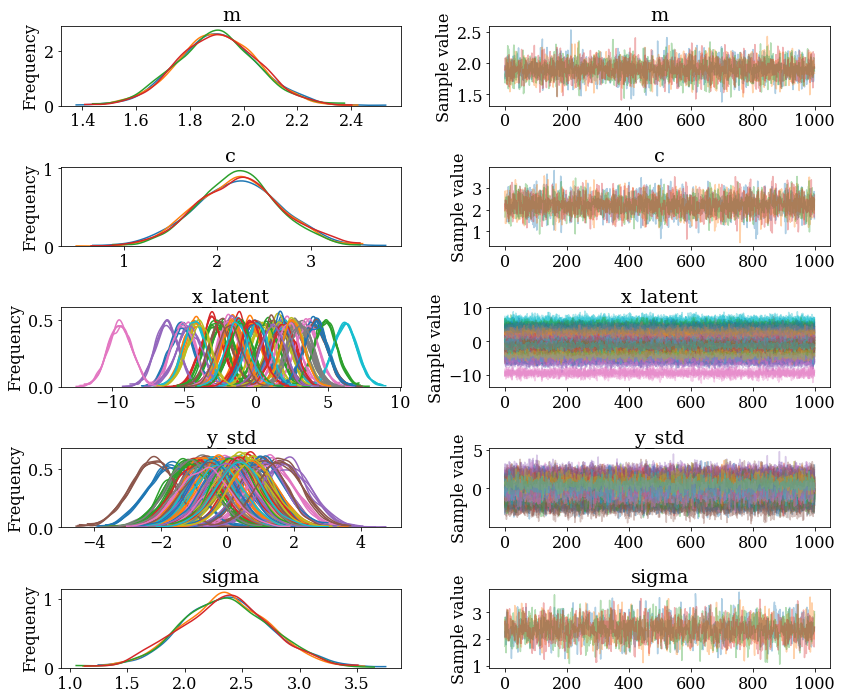

In [103]:
pm.traceplot(trace)

In [104]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,1.90,0.15,0.00,1.61,2.20,4924.51,1.0
c,2.22,0.45,0.01,1.36,3.11,5220.11,1.0
x_latent__0,-5.13,0.86,0.01,-6.74,-3.43,6275.98,1.0
x_latent__1,-0.46,0.81,0.01,-2.03,1.14,8960.42,1.0
x_latent__2,-2.30,0.82,0.01,-3.91,-0.72,7832.63,1.0
x_latent__3,-3.10,0.79,0.01,-4.55,-1.51,7110.97,1.0
x_latent__4,-6.19,0.82,0.01,-7.82,-4.65,6548.91,1.0
x_latent__5,4.10,0.83,0.01,2.43,5.68,7328.84,1.0
x_latent__6,3.51,0.83,0.01,1.94,5.19,6637.43,1.0
x_latent__7,2.56,0.83,0.01,1.00,4.26,7828.96,1.0


/home/davies/.local/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


Text(0, 0.5, 'probability density')

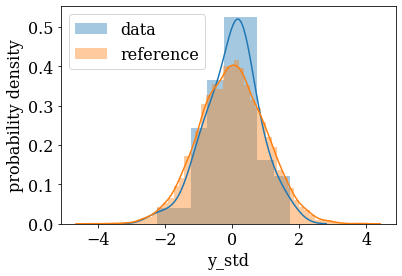

In [118]:
ax = sns.distplot(trace['y_std'].mean(axis=0), label='data')
sns.distplot(np.random.randn(10000), label='reference')
ax.legend()
ax.set_xlabel('y_std')
ax.set_ylabel('probability density')

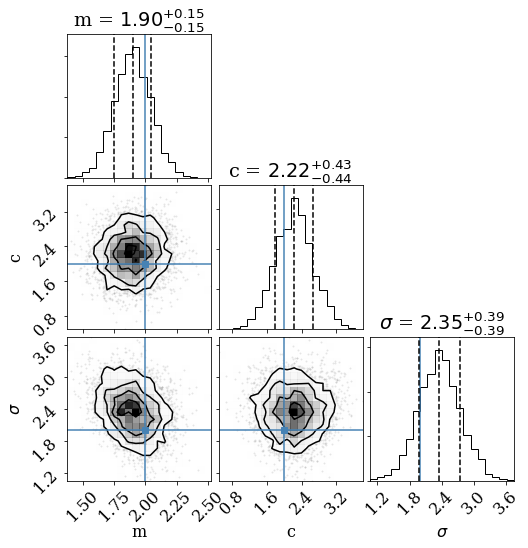

In [106]:
import corner
corner.corner(np.array([trace['m'], trace['c'], trace['sigma']]).T, 
              truths=[2,2,2], 
              labels=['m', 'c', r'$\sigma$'],
              quantiles=[0.16, 0.50, 0.84],
              show_titles=True)
plt.show()

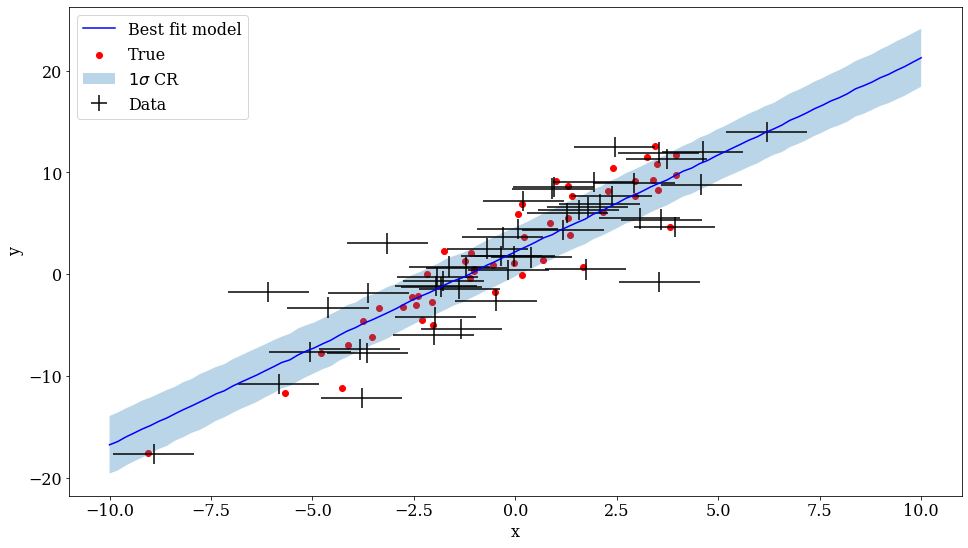

In [107]:
fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(x, y, c='r', label='True')
ax.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err, linestyle='none', c='k', label='Data')

xx = np.linspace(-10, 10, 100)
est = [mm*xx+cc + np.random.randn(len(xx))*sigma for mm, cc, sigma in zip(trace['m'], trace['c'], trace['sigma'])]
std = np.std(est, axis=0)
mean = np.mean(est, axis=0)

ax.plot(xx, mean, c='b', label='Best fit model')
ax.fill_between(xx, mean+std, mean-std, alpha=0.3, label=r'$1 \sigma$ CR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc=2)